<a href="https://colab.research.google.com/github/tnatani/Online-Retail-Customer-Segmentation/blob/main/Copy_of_Online_Retail_Customer_Segmentation_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

**Reading csv file and checking data types and null value information using info**

In [ ]:
data = pd.read_csv("/content/Online Retail.xlsx - Online Retail.csv", encoding = "ISO-8859-1")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


**Data Cleaning and EDA**

**Checking for duplicates if any present**

In [ ]:
print("Shape before dropping duplicates", data.shape)
data = data.drop_duplicates()
print("Shape after dropping duplicates", data.shape)

Shape before dropping duplicates (541909, 8)
Shape after dropping duplicates (536641, 8)


**Checking Data Shape and Unique Values in different columns**

In [ ]:
print("Data Shape", data.shape)
for col in ["InvoiceNo","StockCode","InvoiceDate","CustomerID", "Country"]:
    print("Unique Values for ", col, " - ", data[col].nunique())

Data Shape (536641, 8)
Unique Values for  InvoiceNo  -  25900
Unique Values for  StockCode  -  4070
Unique Values for  InvoiceDate  -  23260
Unique Values for  CustomerID  -  4372
Unique Values for  Country  -  38


**Checking Nulls in CustomerID**

In [ ]:

print(np.sum(data.isnull()), "\n")
print("Percentage of customers missing: ", round(data['CustomerID'].isnull().sum() * 100 / len(data),2),"%" )

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64 

Percentage of customers missing:  25.16 %


**Check if InvoiceNo for Null Customer ID exist in cases where Customer ID is present for filling CustomerID Nulls**

No such cases present as empty dataframe is returned

In [ ]:
null_id_invoices = data[data.CustomerID.isnull()]["InvoiceNo"].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))
### Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
data[~data.CustomerID.isnull()][data.InvoiceNo.isin(null_id_invoices)]

Invoices count with Null Customer ID 3710


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Since the customer ID's are missing, I assume these orders were not made by the customers already in the data set because those customers already have ID's. I also don't want to assign these orders to those customers because this would alter the insights I draw from the data. Instead of dropping the null CustomerID values which amounts to ~25% of data, let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.

Check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer

In [ ]:
data.groupby(['InvoiceNo'])['CustomerID'] \
                             .nunique() \
                             .reset_index(name='nunique') \
                             .sort_values(['nunique'], ascending=False) \
                             .head(5)

,InvoiceNo,nunique
0,536365,1
16915,571200,1
16924,571215,1
16923,571214,1
16922,571213,1


On sorting descending, this data shows that each Invoice relates to maximum of 1 Customer

Creating NewID column and Assigning to InvoiceNo wherever CustomerID is null

In [ ]:
data['NewID'] = data['CustomerID']
data.loc[data['CustomerID'].isnull(), ['NewID']] = data['InvoiceNo']

#Remove all non digits from column NewID (Since Invoice can contains "C" referring to cancellations)
data['NewID'] = data['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
data['NewID'] = pd.to_numeric(data['NewID'])

### Check if presnt customerIds and New Ids have any common values since it would create alter actual Customer Insights
customer = data['CustomerID'].nunique()
null_invoices = data[data.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = data['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Number of Customers + Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


Since both values equal, we know all the different orders that didn't have a customer ID got assigned unique NewID and no duplicates were created

Converting object type to datetime for InvoiceDate and checking first and last date

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
print("Minimum Invoice Date", min(data["InvoiceDate"]))
print("Maximum Invoice Date", max(data["InvoiceDate"]))

Minimum Invoice Date 2010-12-01 08:26:00
Maximum Invoice Date 2011-12-09 12:50:00


Adding cancellations column based on definition that InvoiceNo starts with C

In [ ]:
data["cancellations"] = np.where(data["InvoiceNo"].str.startswith('C'), 1,0)
total_data = data["InvoiceNo"].shape[0]
cancelled_data = data[data.cancellations == 1].shape[0]
print("Number of cancelled products data", cancelled_data, cancelled_data*100/total_data, "\n")

print(data[data.cancellations == 1]["Quantity"].describe())

#### Removing cancellations since they have negative quantities and makes only ~2% of data
data = data[data.cancellations == 0]

Number of cancelled products data 9251 1.7238712658928408 

count     9251.000000
mean       -29.787050
std       1147.997592
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64


This shows that quantity is negative when any order was cancelled. Removed cancellations data since they only make upto ~2% of data

**Analysis of UnitPrice variable**

In [ ]:
print("Minimum UnitPrice", min(data["UnitPrice"]))
print("Maximum UnitPrice", max(data["UnitPrice"]))
data["UnitPrice"].describe()

Minimum UnitPrice -11062.06
Maximum UnitPrice 13541.33


count    527390.000000
mean          3.861939
std          41.963759
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

checking cases where Price <0

In [ ]:
data[data.UnitPrice<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,563186,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,563187,0


Removing these two cases

In [ ]:
data = data[data.UnitPrice >= 0]

All rows where Price == 0

In [ ]:
print("% of data with Price = 0: ", round(len(data[data.UnitPrice == 0]) * 100 / len(data),2),"%" )
print("Count of unique Customer ID values ", data[data.UnitPrice == 0].CustomerID.nunique(), "\n")
data[data.UnitPrice == 0][~data.CustomerID.isnull()].head()

% of data with Price = 0:  0.48 %
Count of unique Customer ID values  31 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,126470,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,165600,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,149110,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,130810,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,130810,0


% of data with Price = 0:  0.48 %
Count of unique Customer ID values  31 

In [ ]:
### Dropping Cases with UnitPrice = 0
data_filtered = data[data.UnitPrice >0]
data_filtered["UnitPrice"].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [ ]:
print("Minimum Quantity", min(data_filtered["Quantity"]))
print("Maximum Quantity", max(data_filtered["Quantity"]))
data_filtered["Quantity"].describe()

Minimum Quantity 1
Maximum Quantity 80995


count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

**Customer and total revenue split wrto country**

In [ ]:
### Adding Monetary information by calculating total value of transaction by multiplying unit price and quantity of the product
data_filtered["Total_sales"] = data_filtered["UnitPrice"]*data_filtered["Quantity"]

### Creating Country Level grouping to find Unique Customer count and %
country_customer_df = data_filtered.groupby("Country")["CustomerID"].nunique().reset_index().rename(columns = \
                                                                                           {"CustomerID":"count_CustomerID"})
country_customer_df["customer_%"] = round(country_customer_df["count_CustomerID"]*\
                                          100/country_customer_df["count_CustomerID"].sum(),2)

### Creating Country Level grouping to find total revenue and %
country_df = data_filtered.groupby("Country")["Total_sales"].sum().reset_index()
country_df["Total_sales%"] = round(country_df["Total_sales"]*100/country_df["Total_sales"].sum(),2)

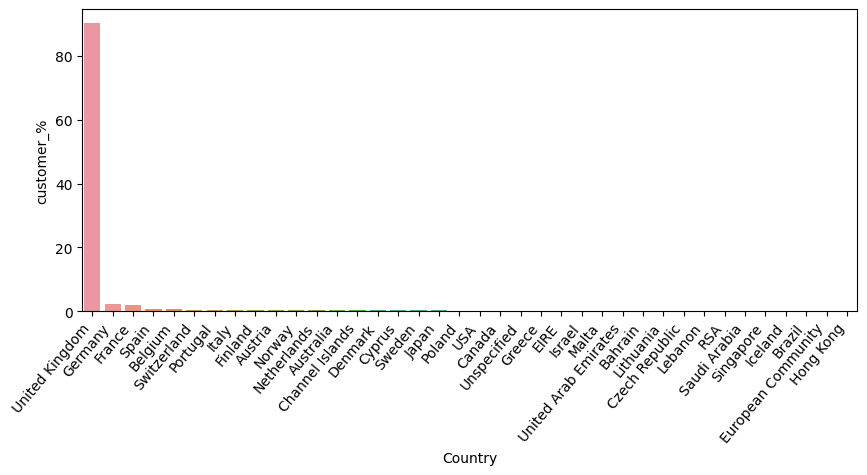

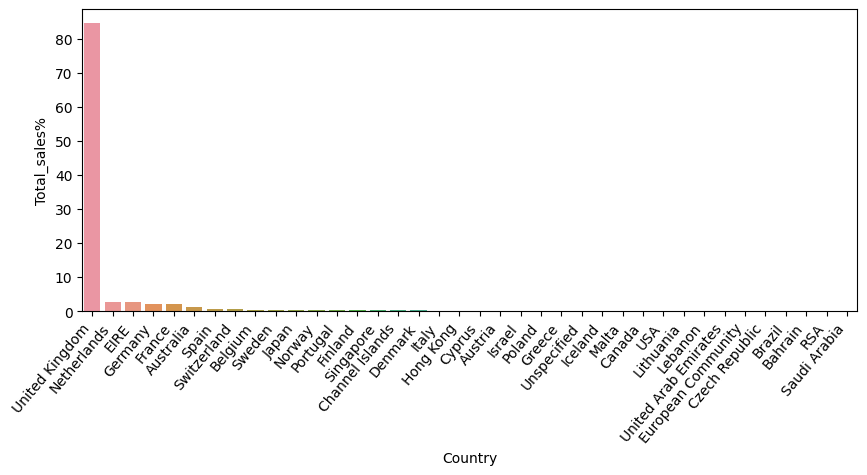

In [ ]:
country_customer_df = country_customer_df.sort_values(by = "customer_%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_customer_df["Country"], y=country_customer_df['customer_%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

country_df = country_df.sort_values(by = "Total_sales%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_df["Country"], y=country_df['Total_sales%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

The United Kingdom not only has the most sales revenue, but also the most customers. Therefore, for the purpose of this analysis, I will be taking data corresponding to orders from the United Kingdom.

In [ ]:
uk_df = data_filtered[data_filtered.Country == "United Kingdom"]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479985 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      479985 non-null  object        
 1   StockCode      479985 non-null  object        
 2   Description    479985 non-null  object        
 3   Quantity       479985 non-null  int64         
 4   InvoiceDate    479985 non-null  datetime64[ns]
 5   UnitPrice      479985 non-null  float64       
 6   CustomerID     349203 non-null  float64       
 7   Country        479985 non-null  object        
 8   NewID          479985 non-null  int64         
 9   cancellations  479985 non-null  int64         
 10  Total_sales    479985 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 43.9+ MB


Checking Most popular products in United Kingdom